In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from tqdm import trange
import pickle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from utils.portfolio_backtests import *
from utils.trading_model import *
from utils.experiment_utils import *
from utils.portfolio_backtests import MeanVariance

from cvx.covariance.ewma import iterated_ewma, _ewma_cov, _ewma_mean
from cvx.covariance.combination import from_sigmas

import datetime
import random

sns.set()
sns.set(font_scale=1.5)

boolUniformlyDistributedDataset = False
percentageOfRemovedDays = 40

In [20]:
# code to make the dataset not uniformly distributed
def datasetNonUniformlyDistributed(returns, rf_rate, D):
    '''
    returns: dataframe of returns
    D: percentage of days to eliminate randomly from the dataset:10 = 10% of the days are eliminated
    '''

    # calculate the size of the dataset(so the lenght of the column)
    datasetSize = len(returns.index)
    number_of_days_to_eliminate = int(datasetSize * D / 100)

    # Define the range of indices that can be removed; avoid the first and last days
    valid_indices = list(range(2, datasetSize - 2)) # Randomly select a group of indices to remove
    indices_to_remove = random.sample(valid_indices, number_of_days_to_eliminate)

    #Randomly select a group of indices to remove
    indices_to_remove = random.sample(valid_indices, number_of_days_to_eliminate)
        
    # Remove rows from the DataFrame that correspond to these indices
    returns = returns.drop(returns.index[indices_to_remove])

    # Aligning rf_rate with the returns DataFrame
    returns, rf_rate_aligned = returns.align(rf_rate, join='left', axis=0)

    # Handling missing values in rf_rate after alignment (if needed)
    rf_rate_aligned.fillna(method='ffill', inplace=True)  # forward fill for missing values

    # print the dimension of the risk-free rate dataframe
    print("rf dataframe dimention: " + str(rf_rate_aligned.shape))

    # print the dimension of the returns dataframe
    print("returns dataframe dimension: " + str(returns.shape))

    return returns, rf_rate_aligned, indices_to_remove # i return the removed dates list: this is the list of the dates that i have removed for sure from the dataset

# Import data

In [21]:
randomIndexes = None
returns = pd.read_csv('data/ff5_no_rf.csv', index_col=0, parse_dates=True)
print("the return dataset has this dimension: ", len(returns))
print("anothe way to tell the size:", len(returns.index))
completeDatasetReturns = returns.copy() # this is a copy used just to adjust the index for mgarch

# Risk-free rate
FF = pd.read_csv('data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

the return dataset has this dimension:  14979
anothe way to tell the size: 14979


In [22]:
'''print("original returns dataframe dimention: " + str(returns.shape))

if not boolUniformlyDistributedDataset:

    returns, rf_rate, randomIndexes = datasetNonUniformlyDistributed(returns, rf_rate, percentageOfRemovedDays)
    print("number of removed days: ", len(randomIndexes))
    
columns = returns.columns
plt.plot((returns[columns]+1).cumprod(axis=0), label=columns)
# fix legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.yscale("log");'''

'print("original returns dataframe dimention: " + str(returns.shape))\n\nif not boolUniformlyDistributedDataset:\n\n    returns, rf_rate, randomIndexes = datasetNonUniformlyDistributed(returns, rf_rate, percentageOfRemovedDays)\n    print("number of removed days: ", len(randomIndexes))\n    \ncolumns = returns.columns\nplt.plot((returns[columns]+1).cumprod(axis=0), label=columns)\n# fix legend\nplt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);\nplt.yscale("log");'

# Covariance predictors

In [23]:
### Parameters
rw_memory = 125
ewma_halflife = 63
iewma_pair = (21,63)
cm_iewma_pairs = [(5, 10), (10, 21), (21, 63), (63, 125), (125, 250)]

In [24]:
# Rolling window 
rw = rolling_window(returns, rw_memory) 

In [25]:
# EWMA
ewma = dict(_ewma_cov(returns, halflife=ewma_halflife))

In [26]:
# IEWMA  
#iewma = list(iterated_ewma(returns, vola_halflife=iewma_pair[0], cov_halflife=iewma_pair[1]))
#iewma = {iterate.time: iterate.covariance for iterate in iewma}

Next we import the precomputed MGARCH predictors (computed using the rmgarch
package in R). We used the first 250 days for training. Hence the first
predictors is given at day 250, and predicts the covariance matrix for day 251.
(Python uses zero-based indexing, so the first predictor will have time index 249.)

In [27]:
# MGARCH precomputed in R due to computational complexity
# The covariance matrices were computed for 100*r for numerical reasons 

mgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/factor_returns/mgarch_ff5.csv", index_col=None)
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, returns.shape[1]) / 10000

if not boolUniformlyDistributedDataset:
    # here dataset is not uniformly distributed; so i have to fix also the dimension of the sigmas by Filter out the rows in Sigmas corresponding to randomDates(randomIndex)
    # Remove first year since it was used for training
    # now get from the returns dataset copy the index of day 249
    dayIndex = completeDatasetReturns.index[249]
    selectedDate = completeDatasetReturns.loc[dayIndex].name

    temp = 249
    # now we have to construct times list that starts from the date or index that we have obtained; use returns dataframe and if that date doesn't exist select the next one
    while selectedDate not in returns.index:
        temp += 1
        dayIndex = completeDatasetReturns.index[temp]

        # now get the date of the day 249
        selectedDate = completeDatasetReturns.loc[dayIndex].name
    
    print("selected date: " + str(selectedDate))
    
    dayIndexInt = completeDatasetReturns.index.get_loc(dayIndex)  # Get integer index for dayIndex

    # so here for sure the selected date is inside the returns dataframe not uniformly distributed
    times = returns.index[returns.index.get_loc(selectedDate):] # here i have removed all the dates of the first year used for training

    # now get the times dimension/size/lenght
    timesDimension = len(times)
    # now i will use the list of the random dates to remove from the sigmas dataframe the rows corresponding to the random dates; i will use the completeDatasetReturns dataframe
    # to find the index of the random date and then i will use the index to remove the row from the sigmas dataframe

    # but first sort the indexes(in ascending order) and remove from the list every index that is before the variable dayIndex
    randomIndexes.sort()
    randomIndexes = [index for index in randomIndexes if index > dayIndexInt]  # Compare with integer index

    # Adjusting Sigmas for the non-uniform distribution
    for index in randomIndexes:
        adjusted_index = completeDatasetReturns.index.get_loc(completeDatasetReturns.index[index]) - timesDimension
        Sigmas = np.delete(Sigmas, adjusted_index, 0)

else:
    # here dataset is uniformly distributed
    # Remove first year since it was used for training
    times = returns.index[249:]

#print("date considered: " + str(selectedDate) + " - " + str(type(selectedDate)))
# print also the lenght of times
#print("times lenght: " + str(len(times)))
#print("random date dimension: " + str(len(randomDates)))
#print("mgarch dataset number of lines: " + str(Sigmas.shape[0]))
# print just the mgarch timestamp
#print("mgarch timestamp: " + str(times[0]) + " - " + str(times[-1]))

mgarch = {times[t]: pd.DataFrame(Sigmas[t], index=returns.columns, columns=returns.columns) for t in range(Sigmas.shape[0])}

selected date: 1964-06-26 00:00:00


AttributeError: 'NoneType' object has no attribute 'sort'

In [ ]:
'''# CM-IEWMA
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

# Regularize the first covariance matrix
fast = cm_iewma_pairs[0]; fast = f"{fast[0]}-{fast[1]}"
Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

cm_iewma = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results}'''

'# CM-IEWMA\niewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}\nSigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}\n\n# Regularize the first covariance matrix\nfast = cm_iewma_pairs[0]; fast = f"{fast[0]}-{fast[1]}"\nSigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)\n\nresults = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))\n\ncm_iewma = {result.time: result.covariance for result in results}\nweights = {result.time: result.weights for result in results}'

In [ ]:
# Prescient 
prescient = {}
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, axis=0)
    prescient[t] = pd.DataFrame(cov+np.outer(mean, mean), index=returns.columns, columns=returns.columns)

# Define end and start dates for backtests

In [ ]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("1965-06-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

In [ ]:
names = ["RW", "EWMA", "MGARCH", "PRESCIENT"]

predictors_temp = [rw, ewma, mgarch, prescient]
predictors = []


for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# CM-IEWMA component weights

In [ ]:
#quarterly_weights  = pd.DataFrame(weights).T.resample("Y").mean().loc[start_date:end_date]

#plt.stackplot(quarterly_weights.index, quarterly_weights.values.T, labels=[f"{pair[0]}-{pair[1]}" for pair in cm_iewma_pairs])
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

In [ ]:
#plt.plot(quarterly_weights.values, label=[f"{pair[0]}-{pair[1]}" for pair in cm_iewma_pairs]);
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

In [ ]:
#halflifes_vola = np.array([cm_iewma_pairs[i][0] for i in range(len(cm_iewma_pairs))])
#(quarterly_weights * halflifes_vola).sum(axis=1).plot()
#plt.axhline((quarterly_weights * halflifes_vola).sum(axis=1).mean(), color="black", linestyle="--", label="Mean half-life", zorder=-1);
#plt.gcf().autofmt_xdate()

# MSEs

In [ ]:
#for i, predictior in enumerate(predictors):
    #MSE_temp = MSE(returns, predictior).resample("Q").mean()

    #print("\n" + names[i])
    #print(f"mean: {MSE_temp.mean():.8f}")
    #print(f"std: {MSE_temp.std():.8f}")
    #print(f"max: {MSE_temp.max():.8f}")

In [ ]:
#plt.figure()
#for i, predictior in enumerate(predictors):
    #MSE_temp = MSE(returns, predictior).resample("Q").mean()
    #MSE_temp.plot()

# Log likelihoods

In [ ]:
log_likelihoods = {}

for i, predictor in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")
    returns_temp = returns.loc[pd.Series(predictor).index].values[1:]
    times = pd.Series(predictor).index[1:]
    Sigmas_temp = np.stack([predictor[t].values for t in predictor.keys()])[:-1]

    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]

Computing RW log-likelihood...


Computing EWMA log-likelihood...
Computing MGARCH log-likelihood...
Computing PRESCIENT log-likelihood...


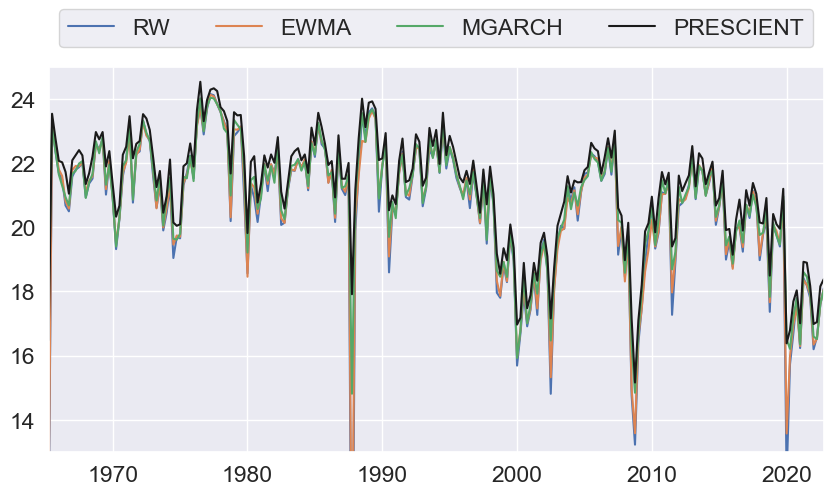

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylim(13,25);

# Regrets

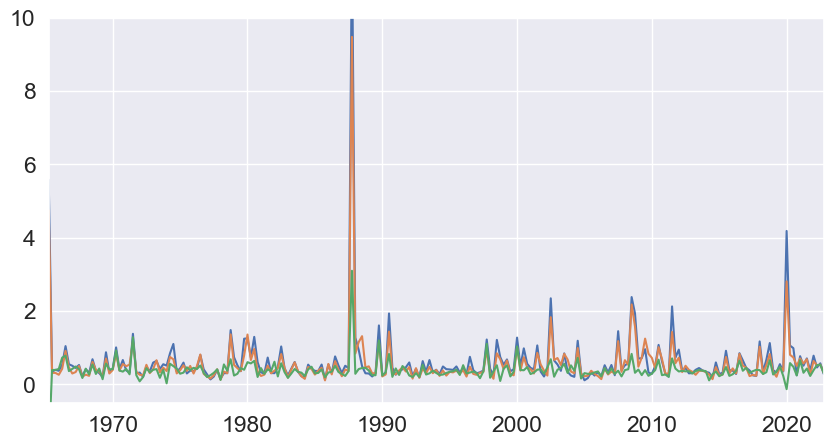

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
# plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.ylim(-0.5,10);


### Compare CM-IEWMA with MGARCH

In [ ]:
#regret_mgarch = regrets["MGARCH"].resample("Q").mean()
#regret_cm_iewma = regrets["CM-IEWMA"].resample("Q").mean()

#regret_mgarch.plot(label="MGARCH")
#regret_cm_iewma.plot(label="CM-IEWMA");
# plt.legend();

In [ ]:
#cm_iewma_advantage = (regret_cm_iewma - regret_mgarch < 0).mean()
#print(f"CM-IEWMA is better than MGARCH {cm_iewma_advantage:.0%} of the time")

### Regret CDF plots

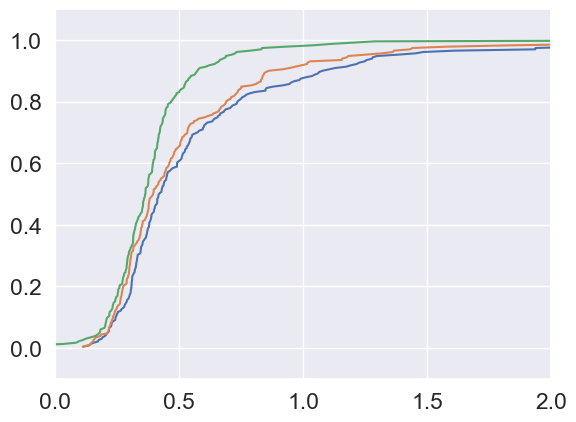

In [ ]:
for name in log_likelihoods:
    if name != "PRESCIENT":
        data = regrets[name].resample("Q").mean().values
        x, y = ecdf(data)
        plt.plot(x, y, label=name)
plt.xlim(0,2)
plt.ylim(-0.1,1.1);
# plt.legend();

### Regret metrics

In [ ]:
print("\\begin{tabular}{lccccc}")
print("   \\toprule")
print("   Predictor & Average & Std.~dev. & Max \\\\")
print("   \\midrule")

for name in regrets:
    if name != "PRESCIENT":
        print("   {}".format(name), end=" & ")
        regret = regrets[name].resample("Q").mean()
        metrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        print("{} & {} & {} \\\\".format(metrics[0], metrics[1], metrics[2]))

print("   \\hline")
print("   PRESCIENT & 0.0 & 0.0 & 0.0 \\\\")
print("   \\bottomrule")
print("\\end{tabular}")


\begin{tabular}{lccccc}
   \toprule
   Predictor & Average & Std.~dev. & Max \\
   \midrule
   RW & 0.6 & 0.9 & 12.2 \\
   EWMA & 0.6 & 0.7 & 9.5 \\
   MGARCH & 0.4 & 0.3 & 3.1 \\
   \hline
   PRESCIENT & 0.0 & 0.0 & 0.0 \\
   \bottomrule
\end{tabular}


# Portfolio optimization

In [ ]:
# Risk-free rate for backtest period; for cash allocation end_date removed since
# it is removed in returns (in shift(-1)) to make predictors causal
rf = rf_rate.loc[start_date:end_date].iloc[:-1]

# Portfolio paramaters
additonal_cons={"short_lim":1.6, "upper_bound":0.4,\
             "lower_bound":-0.3}

# Volatility target
sigma_tar = 0.02
excess = False

### Equally weighted

In [ ]:
def yearly_SR(trader):
    rets = pd.Series(trader.rets.flatten(), index=trader.returns.index)

    means = rets.resample("Y").mean() * 252
    stds = rets.resample("Y").std() * np.sqrt(252)

    return means / stds


In [ ]:
#trader = traders_eq_w["CM-IEWMA"]
#SRs = yearly_SR(trader)

In [ ]:
traders_eq_w = EqWeighted(returns, predictors, names, start_date, end_date).backtest()

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:34<00:00,  8.54s/it]


In [ ]:
create_table(traders_eq_w, sigma_tar, rf, excess)



name:  RW
the trader object is:  <utils.trading_model.Trader object at 0x0000021C456315D0>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0


name:  EWMA
the trader object is:  <utils.trading_model.Trader object at 0x0000021C3F037390>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0


name:  MGARCH
the trader object is:  <utils.trading_model.Trader object at 0x0000021C3EFDC3D0>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0


name:  PRESCIENT
the trader object is:  <utils.trading_model.Trader object at 0x0000021C3F010910>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0
metrics before calling _create_table_helper function:  {'RW': metrics(mean_return=0.028793962512495167,

### Minimum risk

In [ ]:
traders_min_risk = MinRisk(returns, predictors, names, start_date, end_date).backtest(additonal_cons)

100%|██████████| 4/4 [03:31<00:00, 52.99s/it]


In [ ]:
#trader = traders_min_risk["CM-IEWMA"]
#SRs = yearly_SR(trader)
#plt.legend().remove()

In [ ]:
create_table(traders_min_risk, sigma_tar, rf, excess)



name:  RW
the trader object is:  <utils.trading_model.Trader object at 0x0000021C3F0125D0>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0000000000000062


name:  EWMA
the trader object is:  <utils.trading_model.Trader object at 0x0000021C00017A10>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  0.9999999999999987


name:  MGARCH
the trader object is:  <utils.trading_model.Trader object at 0x0000021C3EFB3B10>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0000000000000289


name:  PRESCIENT
the trader object is:  <utils.trading_model.Trader object at 0x0000021C01418090>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0000000000000007
metrics before calling _create_table_helper

### Maximum diversification 

In [ ]:
traders_max_diverse = MaxDiverse(returns, predictors, names, start_date, end_date).backtest(additonal_cons)

100%|██████████| 4/4 [03:06<00:00, 46.58s/it]


In [ ]:
create_table(traders_max_diverse, sigma_tar, rf, excess)



name:  RW
the trader object is:  <utils.trading_model.Trader object at 0x0000021C419EBF90>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0


name:  EWMA
the trader object is:  <utils.trading_model.Trader object at 0x0000021C000153D0>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0


name:  MGARCH
the trader object is:  <utils.trading_model.Trader object at 0x0000021C000070D0>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0


name:  PRESCIENT
the trader object is:  <utils.trading_model.Trader object at 0x0000021C3F075110>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0
metrics before calling _create_table_helper function:  {'RW': metrics(mean_return=0.014317678450224547,

### Risk parity 

In [ ]:
traders_risk_par = RiskParity(returns, predictors, names, start_date, end_date).backtest()

100%|██████████| 4/4 [03:42<00:00, 55.59s/it]


In [ ]:
create_table(traders_risk_par, sigma_tar, rf, excess)



name:  RW
the trader object is:  <utils.trading_model.Trader object at 0x0000021C3F056650>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  0.9999999999999999


name:  EWMA
the trader object is:  <utils.trading_model.Trader object at 0x0000021C41087690>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0


name:  MGARCH
the trader object is:  <utils.trading_model.Trader object at 0x0000021C3F036710>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0


name:  PRESCIENT
the trader object is:  <utils.trading_model.Trader object at 0x0000021C3D564A50>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0
metrics before calling _create_table_helper function:  {'RW': metrics(mean_return=0.0160

In [ ]:
def tune_returns(returns):
    """
    Cuts element in each row at its 40th and 60th percentile
    up and down
    """
    
    returns_tuned = np.zeros_like(returns)

    for t in range(returns.shape[0]):
        r_temp = returns.iloc[t]
        returns_tuned[t] = np.clip(r_temp, a_min=r_temp.quantile(0.4), a_max=r_temp.quantile(0.6))

    return pd.DataFrame(returns_tuned, index=returns.index, columns=returns.columns)

### Mean variance

In [ ]:
r_hat_ewma1 = pd.DataFrame(dict(_ewma_mean(returns, halflife=1))).T
r_hat_ewma5 = pd.DataFrame(dict(_ewma_mean(returns, halflife=5))).T
r_hat_ewma10 = pd.DataFrame(dict(_ewma_mean(returns, halflife=10))).T
r_hat_ewma21 = pd.DataFrame(dict(_ewma_mean(returns, halflife=21))).T
r_hat_ewma63 = pd.DataFrame(dict(_ewma_mean(returns, halflife=63))).T

mean_predictors = [r_hat_ewma1, r_hat_ewma5, r_hat_ewma10, r_hat_ewma21, r_hat_ewma63]
cov_predictors = [cm_iewma for _ in range(len(mean_predictors))]

traders_mean_var = MeanVariance(returns, cov_predictors, ["1", "5", "10", "21", "63"], mean_predictors=mean_predictors, start_date=start_date, end_date=end_date).backtest(additonal_cons, sigma_tar)

NameError: name 'cm_iewma' is not defined

In [ ]:
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 1-day EWMA from 2010
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 5-day EWMA from 2010
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 10-day EWMA from 2010
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 21-day EWMA from 2010
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 63-day EWMA from 2010
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 250-day EWMA from 2010
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
SRs.loc["2010-01-01":].mean()

In [ ]:
# 1-day EWMA
trader = traders_mean_var["1"]
trader.returns = trader.R
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 5-day EWMA
trader = traders_mean_var["5"]
trader.returns = trader.R
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 5-day EWMA
trader = traders_mean_var["63"]
trader.returns = trader.R
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 63-day EWMA
trader = traders_mean_var["CM-IEWMA"]
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 250-day EWMA
trader = traders_mean_var["CM-IEWMA"]
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 250-day EWMA plus clipping
trader = traders_mean_var["CM-IEWMA"]
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 250-day EWMA + clipping 
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 250-day EWMA 
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
create_table(traders_mean_var, None, rf, excess)